In [21]:
# Import libraries and process training and test data
import scipy
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

mnist = scipy.io.loadmat('/Users/pranavreddy/Desktop/ECE 174/Project1/mnist.mat')

trainX = np.array(mnist['trainX'])
trainY = np.array(mnist['trainY']).transpose().astype(int)

trainX = trainX / np.max(trainX)

testX = np.array(mnist['testX']).astype(float)
testY = np.array(mnist['testY']).transpose()

testX = testX / np.max(testX)

labels = np.arange(0, 10)

In [22]:
# Generate random matrices
# I fixed seed for reproducibility when comparing difference feature mappings
L = 1000
np.random.seed(123)
W = np.random.normal(0, 1, (trainX.shape[1], L))
b = np.random.normal(0,1, (1, L))
b = np.repeat(b, trainX.shape[0], axis=0)

# Helper methods to apply feature mappings given random matrices W and b
def identity(x, W, b):
    n = (x.shape)[0]
    return np.hstack((np.ones((n,1)), np.matmul(x, W)+b[:n, :W.shape[1]]))
def sin(x, W, b):
    n = (x.shape)[0]
    x = np.matmul(x, W)+b[:n, :W.shape[1]]
    x = np.sin(2 * np.pi * x / 180)
    return np.hstack((np.ones((n,1)), x))
def relu(x, W, b):
    n = (x.shape)[0]
    x = np.matmul(x, W)+b[:n, :W.shape[1]]
    x = x * (x > 0)
    return np.hstack((np.ones((n,1)), x))
def sigmoid(x, W, b):
    n = (x.shape)[0]
    x = np.matmul(x, W)+b[:n, :W.shape[1]]
    x = scipy.special.expit(x)
    return np.hstack((np.ones((n,1)), x))

# Compute feature mappings
identity_train_X = identity(trainX, W, b)
identity_test_X = identity(testX, W, b)

sigmoid_train_X = sigmoid(trainX, W, b)
sigmoid_test_X = sigmoid(testX, W, b)

sin_train_X = sin(trainX, W, b)
sin_test_X = sin(testX, W, b)

relu_train_X = relu(trainX, W, b)
relu_test_X = relu(testX, W, b)

In [23]:
# Helper methods to create models for each different feature mapping

def create_model(x, y, labels):
    model = np.empty((10,10, x.shape[1]))

    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            mask = ((y[:,0] == labels[i]) | (y[:,0] == labels[j]))
            filtered_Y = y[mask]
            filtered_X = x[mask]

            filtered_Y[filtered_Y == labels[j]] = -1
            filtered_Y[filtered_Y == labels[i]] = 1
            model_ij = np.matmul(np.matmul(np.linalg.pinv(np.matmul(filtered_X.transpose(),filtered_X)),filtered_X.transpose()),filtered_Y)
            model[i,j,:] = model_ij[:,0]
    return model
def predict_one_vs_one(x, model, labels):
    votes = np.zeros((x.shape[0], labels.shape[0]))
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            prediction_ij = np.matmul(x, model[i,j,:])
            votes[prediction_ij > 0,i] = votes[prediction_ij > 0,i] + 1
            votes[prediction_ij < 0,j] = votes[prediction_ij < 0,j] + 1
    predictions = np.argmax(votes, axis=1)
    return predictions

# Helper methods to analyze errors and generate confusion matrices

def create_model_error_analysis(trueY, predictions):
    error = 0
    for i in range(len(predictions)):
        if(predictions[i] != trueY[i]):
            error = error + 1
    error = (error / len(trueY)) * 100
    return error
def plot_confusion_matrix(trueY, predictions, labels, colors, feature_type, data_type):
    display=metrics.ConfusionMatrixDisplay.from_predictions(trueY, predictions,labels=labels, cmap=colors)
    plt.title(f'Error: {create_model_error_analysis(trueY, predictions):.2f}%')
    display.figure_.savefig(f'/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_one_{data_type.lower()}_confusion_matrix_{feature_type}.eps')
    plt.show()

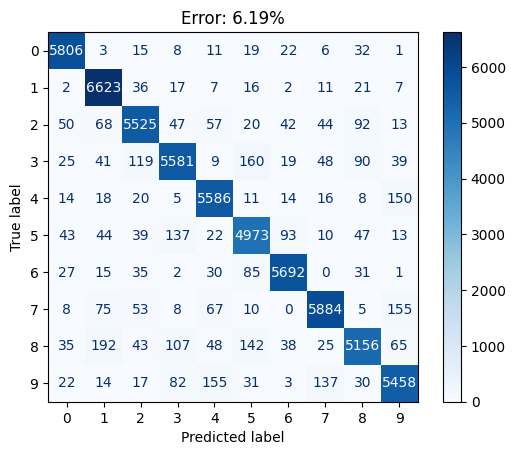

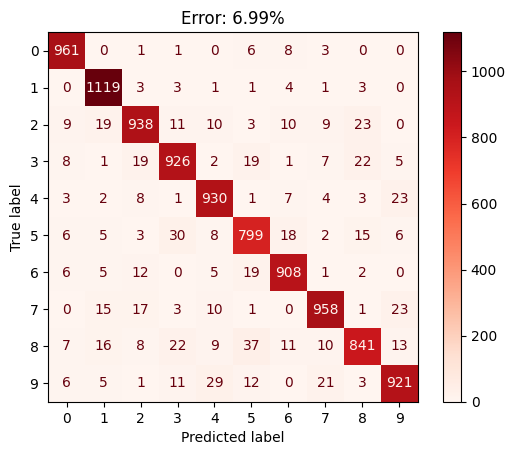

In [24]:
# Compute and create error analysis of identity feature mapping

one_vs_one_model=create_model(identity_train_X, trainY, labels)
one_vs_one_train_predictions = predict_one_vs_one(identity_train_X, one_vs_one_model, labels)
one_vs_one_test_predictions = predict_one_vs_one(identity_test_X, one_vs_one_model, labels)

plot_confusion_matrix(trainY, one_vs_one_train_predictions, labels, 'Blues', "Identity", "Training")
plot_confusion_matrix(testY, one_vs_one_test_predictions, labels, 'Reds', "Identity", "Test")

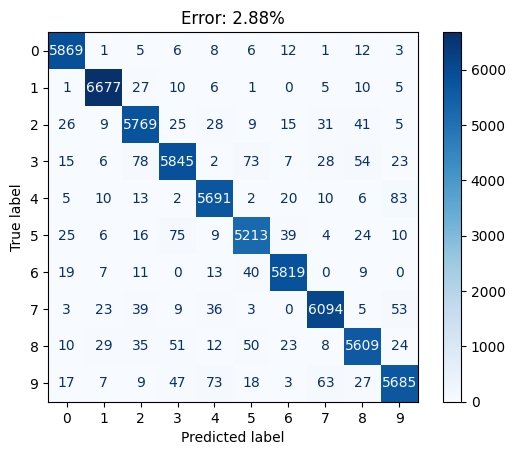

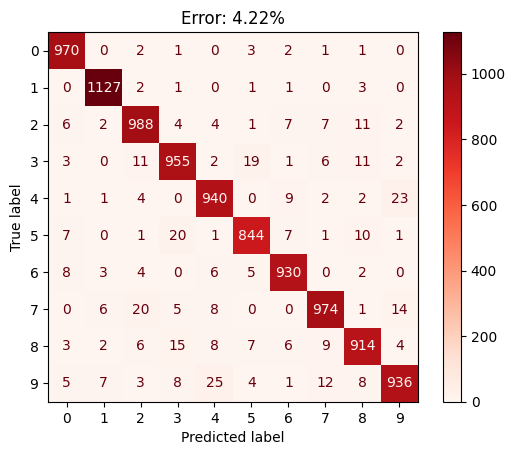

In [25]:
# Compute and create error analysis of sigmoid feature mapping

one_vs_one_model = create_model(sigmoid_train_X, trainY, labels)
one_vs_one_train_predictions = predict_one_vs_one(sigmoid_train_X, one_vs_one_model, labels)
one_vs_one_test_predictions = predict_one_vs_one(sigmoid_test_X, one_vs_one_model, labels)

plot_confusion_matrix(trainY, one_vs_one_train_predictions, labels, 'Blues', "Sigmoid", "Training")
plot_confusion_matrix(testY, one_vs_one_test_predictions, labels, 'Reds', "Sigmoid", "Test")

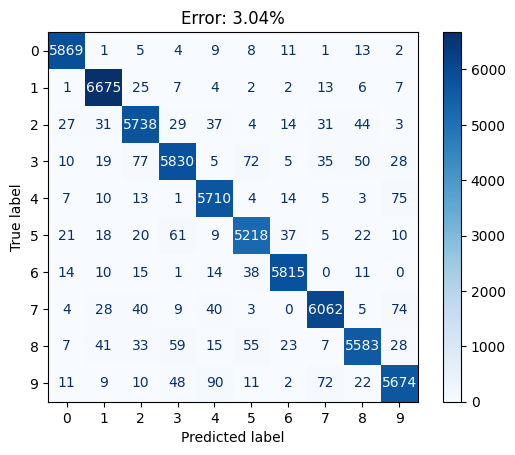

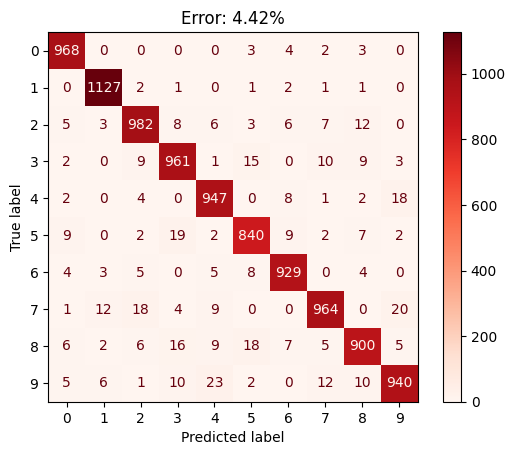

In [26]:
# Compute and create error analysis of sinusoid feature mapping

one_vs_one_model=create_model(sin_train_X, trainY, labels)
one_vs_one_train_predictions = predict_one_vs_one(sin_train_X, one_vs_one_model, labels)
one_vs_one_test_predictions = predict_one_vs_one(sin_test_X, one_vs_one_model, labels)

plot_confusion_matrix(trainY, one_vs_one_train_predictions, labels, 'Blues', "Sine", "Training")
plot_confusion_matrix(testY, one_vs_one_test_predictions, labels, 'Reds', "Sine", "Test")

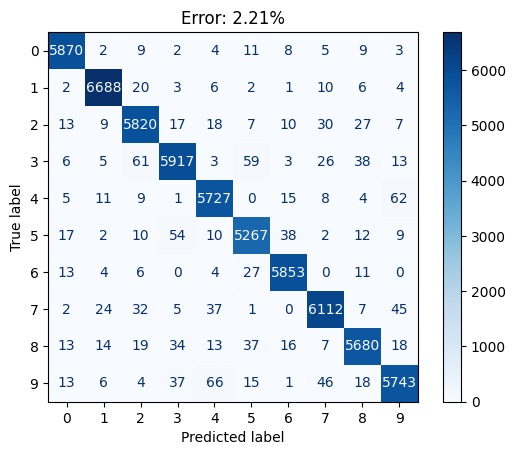

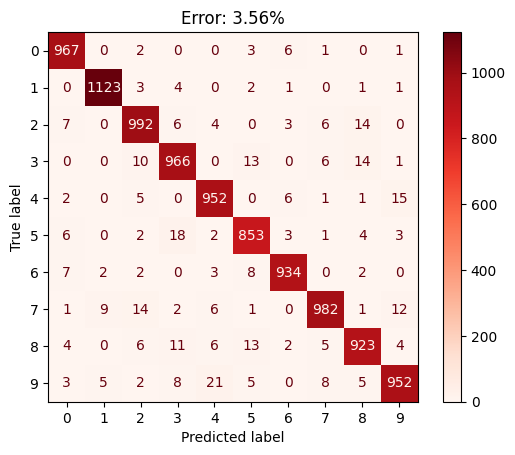

In [27]:
# Compute and create error analysis of ReLU feature mapping

one_vs_one_model=create_model(relu_train_X, trainY, labels)
one_vs_one_train_predictions = predict_one_vs_one(relu_train_X, one_vs_one_model, labels)
one_vs_one_test_predictions = predict_one_vs_one(relu_test_X, one_vs_one_model, labels)

plot_confusion_matrix(trainY, one_vs_one_train_predictions, labels, 'Blues', "ReLU", "Training")
plot_confusion_matrix(testY, one_vs_one_test_predictions, labels, 'Reds', "ReLU", "Test")

In [18]:
# Code to generate models with varying number of features and compute error rate for each
L_range = np.arange(1, 1002, 100)

identity_training_error  = np.empty(L_range.shape)
identity_test_error  = np.empty(L_range.shape)

sigmoid_training_error  = np.empty(L_range.shape)
sigmoid_test_error  = np.empty(L_range.shape)

sin_training_error  = np.empty(L_range.shape)
sin_test_error  = np.empty(L_range.shape)

relu_training_error  = np.empty(L_range.shape)
relu_test_error  = np.empty(L_range.shape)

for i in range(len(L_range)):
    identity_train_X = identity(trainX, W[:,:L_range[i]], b)
    identity_test_X = identity(testX, W[:,:L_range[i]], b)
    one_vs_one_model=create_model(identity_train_X, trainY, labels)
    one_vs_one_train_predictions = predict_one_vs_one(identity_train_X, one_vs_one_model, labels)
    one_vs_one_test_predictions = predict_one_vs_one(identity_test_X, one_vs_one_model, labels)
    identity_training_error[i] = create_model_error_analysis(trainY, one_vs_one_train_predictions)
    identity_test_error[i] = create_model_error_analysis(testY, one_vs_one_test_predictions)

    sigmoid_train_X = sigmoid(trainX, W[:,:L_range[i]], b)
    sigmoid_test_X = sigmoid(testX, W[:,:L_range[i]], b)
    one_vs_one_model=create_model(sigmoid_train_X, trainY, labels)
    one_vs_one_train_predictions = predict_one_vs_one(sigmoid_train_X, one_vs_one_model, labels)
    one_vs_one_test_predictions = predict_one_vs_one(sigmoid_test_X, one_vs_one_model, labels)
    sigmoid_training_error[i] = create_model_error_analysis(trainY, one_vs_one_train_predictions)
    sigmoid_test_error[i] = create_model_error_analysis(testY, one_vs_one_test_predictions)

    sin_train_X = sin(trainX, W[:,:L_range[i]], b)
    sin_test_X = sin(testX, W[:,:L_range[i]], b)
    one_vs_one_model=create_model(sin_train_X, trainY, labels)
    one_vs_one_train_predictions = predict_one_vs_one(sin_train_X, one_vs_one_model, labels)
    one_vs_one_test_predictions = predict_one_vs_one(sin_test_X, one_vs_one_model, labels)
    sin_training_error[i] = create_model_error_analysis(trainY, one_vs_one_train_predictions)
    sin_test_error[i] = create_model_error_analysis(testY, one_vs_one_test_predictions)

    relu_train_X = relu(trainX, W[:,:L_range[i]], b)
    relu_test_X = relu(testX, W[:,:L_range[i]], b)
    one_vs_one_model=create_model(relu_train_X, trainY, labels)
    one_vs_one_train_predictions = predict_one_vs_one(relu_train_X, one_vs_one_model, labels)
    one_vs_one_test_predictions = predict_one_vs_one(relu_test_X, one_vs_one_model, labels)
    relu_training_error[i] = create_model_error_analysis(trainY, one_vs_one_train_predictions)
    relu_test_error[i] = create_model_error_analysis(testY, one_vs_one_test_predictions)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


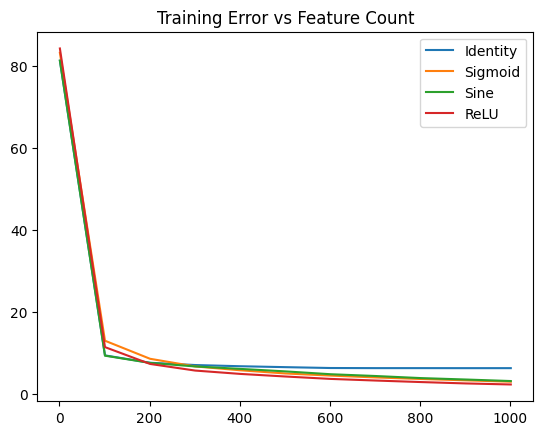

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


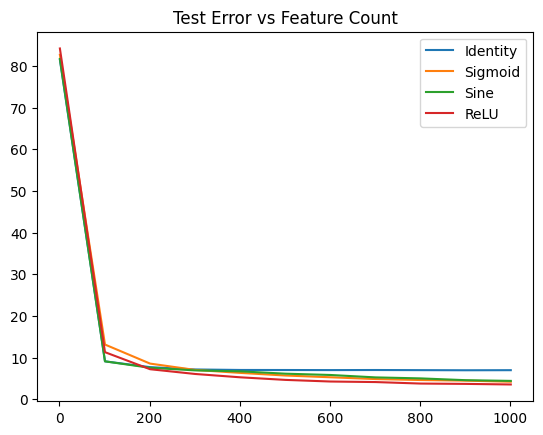

In [20]:
# Plot graphs of Error Rate vs Feature Count for each feature mapping on training dataset
plt.plot(L_range, identity_training_error, label = "Identity")
plt.plot(L_range, sigmoid_training_error, label = "Sigmoid")
plt.plot(L_range, sin_training_error, label = "Sine")
plt.plot(L_range, relu_training_error, label = "ReLU")
plt.legend()
plt.title('Training Error vs Feature Count')
plt.savefig(f'/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_one_training_error_vs_features.eps', format='eps')
plt.show()

# Plot graphs of Error Rate vs Feature Count for each feature mapping on test dataset
plt.plot(L_range, identity_test_error, label = "Identity")
plt.plot(L_range, sigmoid_test_error, label = "Sigmoid")
plt.plot(L_range, sin_test_error, label = "Sine")
plt.plot(L_range, relu_test_error, label = "ReLU")
plt.legend()
plt.title('Test Error vs Feature Count')
plt.savefig(f'/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_one_test_error_vs_features.eps', format='eps')
plt.show()